Deliverables



1. A report (in the form of a presentation, both verbal and through a slides)


2. A github repository containing your jupyter notebook that walks through the pipeline along with the .py files necessary to reproduce your model.



In [1]:
import wrangle
import pandas as pd
import numpy as np
import evaluate
import explore
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score
from scipy import stats
import split_scale
import feature_selection
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [2]:
#use wrangle.py to import data from mySQL
df =wrangle.get_data_from_sql()

In [3]:
# check DF head
df.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
0,2.0,3.0,1458.0,6037.0,8284.0,1.0,97318.0,1970.0,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23
1,1.0,2.0,1421.0,6037.0,6707.0,NaN,96018.0,1911.0,33999877.0,-118291863.0,35606.0,543.69,2017-06-30
2,3.0,4.0,2541.0,6059.0,4975.0,NaN,96958.0,2003.0,33694636.0,-117912245.0,880456.0,9819.72,2017-06-01
3,2.0,3.0,1650.0,6037.0,7300.0,NaN,96037.0,1949.0,33985377.0,-118361620.0,614000.0,7673.19,2017-06-01
4,1.0,2.0,693.0,6037.0,2908.0,NaN,96023.0,1921.0,34112946.0,-118208106.0,274237.0,3267.47,2017-06-29


In [4]:
# check DF tail
df.tail()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date
14985,3.0,5.0,2526.0,6059.0,7800.0,1.0,97018.0,1994.0,33753643.0,-117766503.0,458903.0,5718.72,2017-06-30
14986,3.0,5.0,2735.0,6059.0,7100.0,1.0,97067.0,1963.0,33783173.0,-117817799.0,115387.0,1465.88,2017-06-30
14987,2.0,3.0,1536.0,6037.0,8818.0,1.0,96523.0,1955.0,34058178.0,-117948180.0,297097.0,3519.78,2017-06-30
14988,3.0,5.0,2655.0,6059.0,6000.0,NaN,97065.0,1994.0,33836898.0,-117801369.0,746963.0,8065.50,2017-06-30
14989,3.0,4.0,2305.0,6037.0,5742.0,NaN,96129.0,1949.0,33952368.0,-118441155.0,579047.0,6996.21,2017-06-30


In [5]:
# there are null values in lot_size, pool, zip_code, year_built and tax-value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14990 entries, 0 to 14989
Data columns (total 13 columns):
bathrooms           14990 non-null float64
bedrooms            14990 non-null float64
square_feet         14990 non-null float64
fips                14990 non-null float64
lot_size            14893 non-null float64
pool                3287 non-null float64
zip_code            14982 non-null float64
year_built          14974 non-null float64
latitude            14990 non-null float64
longitude           14990 non-null float64
assessed_value      14990 non-null float64
tax_value           14989 non-null float64
transaction_date    14990 non-null object
dtypes: float64(12), object(1)
memory usage: 1.5+ MB


In [6]:
#wrangle data to remove NANs
df = wrangle.wrangle_zillow()

In [7]:
#create a new column tax-rate
df['tax_rate'] = df.tax_value/df.assessed_value

In [8]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270


In [9]:
#https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697
#source for county fips code. Read codes in a data DataFrame named fips_codes
#fips_codes = pd.read_clipboard()

In [10]:
fips_code = pd.DataFrame({
    'fips': [6037, 6059, 6111],
    'County':['Los Angles', 'Orange', 'Ventura']
})
fips_code.head()

,fips,County
0,6037,Los Angles
1,6059,Orange
2,6111,Ventura


In [11]:
#merge df and fips_codes 
df = pd.merge(df, fips_code, left_on='fips', right_on='fips', how='left')

In [12]:
df.head(2)

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County
0,2.0,3.0,1458.0,6037,8284,1,97318,1970,34686163.0,-118113100.0,136104.0,2319.90,2017-06-23,0.017045,Los Angles
1,1.0,2.0,1421.0,6037,6707,0,96018,1911,33999877.0,-118291863.0,35606.0,543.69,2017-06-30,0.015270,Los Angles


In [34]:
#split the data into train and test
train, test = train_test_split(df, train_size = .70, random_state = 100)

# Data Exploration (Using train data only)

In [35]:
#create a subset of df with continuous variables to create pairplot
train_plot = df[['bathrooms', 'bedrooms', 'square_feet', 'lot_size', 'assessed_value']]

In [36]:
train_plot.head(2)

,bathrooms,bedrooms,square_feet,lot_size,assessed_value
0,2.0,3.0,1458.0,8284,136104.0
1,1.0,2.0,1421.0,6707,35606.0


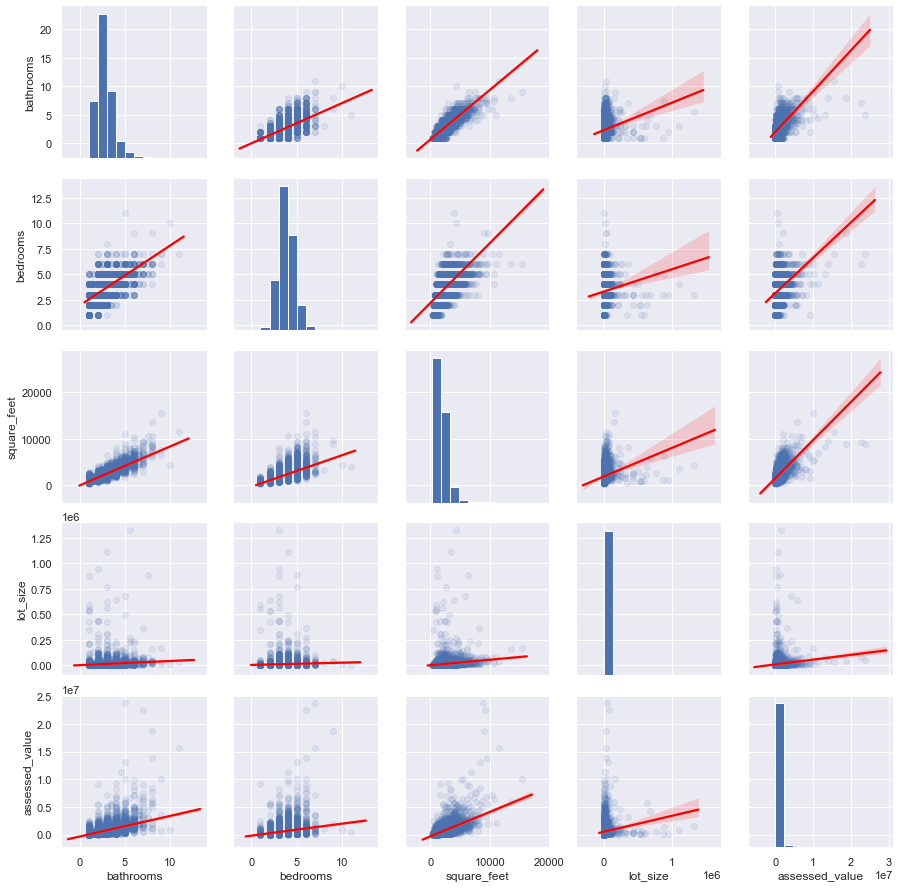

In [37]:
explore.plot_variable_pairs(train_plot)

# Home value seems to be correlated to number of bathrooms, bedrooms, square_feet and lot size

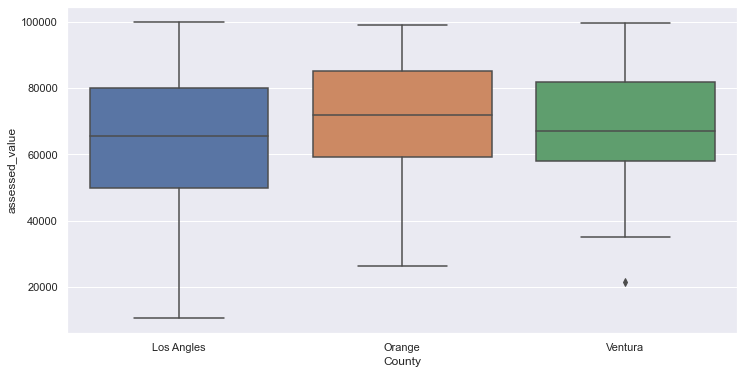

In [38]:
# Lets look at box plot of home values in each county. For better visualization, homes above 1 million are not plotted
plt.figure(figsize=(12,6))
sns.boxplot(x= train[train.assessed_value<100000].County, y= train[train.assessed_value<100000].assessed_value, data=train[train.assessed_value<100000])

In [39]:
train.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County
11938,3.0,3.0,2130.0,6037,7242,1,97319,1988,34663693.0,-118185301.0,268557.0,3975.61,2017-06-22,0.014804,Los Angles
790,2.0,4.0,1705.0,6037,7412,1,96389,1960,34178821.0,-118607295.0,95849.0,1296.19,2017-05-03,0.013523,Los Angles
3846,2.0,3.0,2014.0,6037,6491,0,96246,1936,33774191.0,-118123557.0,324613.0,3968.00,2017-05-17,0.012224,Los Angles
14846,3.0,3.0,2376.0,6059,4500,0,97067,1989,33788519.0,-117766101.0,499860.0,6082.08,2017-06-30,0.012168,Orange
1469,2.0,3.0,1360.0,6037,5200,0,96012,1965,34087088.0,-118200703.0,517777.0,6302.17,2017-05-05,0.012172,Los Angles


In [40]:
# median value of homes is a better measure of central tendency for home values due to outliers.
train[train.assessed_value <1000000].assessed_value.median()

344387.0

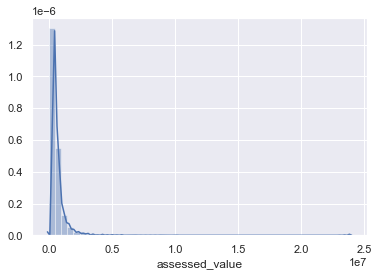

In [41]:
# plot showing distribution of home values. This looks like right skewed distribution
sns.distplot(train.assessed_value)

In [42]:
cm = train_plot.corr()
cm

,bathrooms,bedrooms,square_feet,lot_size,assessed_value
bathrooms,1.000000,0.643196,0.855253,0.140262,0.516795
bedrooms,0.643196,1.000000,0.630065,0.069576,0.273758
square_feet,0.855253,0.630065,1.000000,0.182419,0.602603
lot_size,0.140262,0.069576,0.182419,1.000000,0.116572
assessed_value,0.516795,0.273758,0.602603,0.116572,1.000000


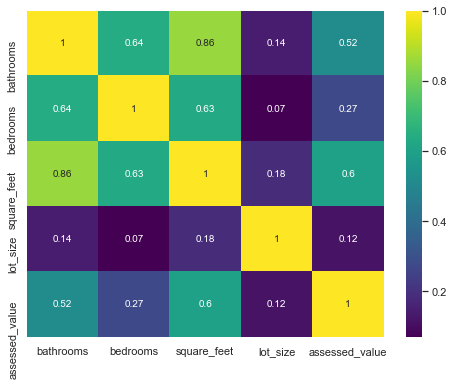

In [43]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

# $H_0$: there is no relationship between home values and number of bedrooms, bathrooms and square_feet
# $H_a$: There is a relationship between home values and number of bedrooms, bathrooms and square_feet

In [44]:
#Lets take a look at simple model based on bathoom, bedroom and squarefeet and compare if against the baseline(median home value)
X_train = train[['bedrooms', 'bathrooms', 'square_feet']]
y_train = train[['assessed_value']]
y_train['y_baseline'] = train['assessed_value'].median()

In [45]:
y_train.head()

,assessed_value,y_baseline
11938,268557.0,389610.0
790,95849.0,389610.0
3846,324613.0,389610.0
14846,499860.0,389610.0
1469,517777.0,389610.0


In [46]:
# Calculating the baseline (based on median) RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_bl = sqrt(mean_squared_error(y_train.assessed_value, y_train.y_baseline))

rmse_bl

734625.2550096865

In [47]:
#We now create a OLS model based on bedrooms, bathrooms and square_feet
from statsmodels.formula.api import ols

# generate parameters, i.e. create model
ols_model = ols('assessed_value ~ bedrooms + bathrooms + square_feet', data = train).fit()

# compute predictions and add to original dataframe
y_train['yhat'] = ols_model.predict(X_train)

In [48]:
y_train.head()

,assessed_value,y_baseline,yhat
11938,268557.0,389610.0,718051.869254
790,95849.0,389610.0,316295.362143
3846,324613.0,389610.0,606590.711377
14846,499860.0,389610.0,832519.897568
1469,517777.0,389610.0,302273.270250


In [49]:
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         assessed_value   R-squared:                       0.367
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     2007.
Date:                Wed, 08 Apr 2020   Prob (F-statistic):               0.00
Time:                        15:08:48   Log-Likelihood:            -1.5278e+05
No. Observations:               10411   AIC:                         3.056e+05
Df Residuals:                   10407   BIC:                         3.056e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -5989.8197    2.1e+04     -0.285      0.776   -4.72e+04    3.52e+04
bedrooms    -1.465e+05   8045.351    -18.211      0.000   -1.62e+05   -1.31e+05
bathrooms    5.748e+04    1.1e+04      5.220      0.000    3.59e+04    7.91e+04
square_feet   465.3172     11.199     41.549      0.000     443.364     487.270
==============================================================================
Omnibus:                    16670.764   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         26785887.300
Skew:                          10.040   Prob(JB):                         0.00
Kurtosis:                     250.679   Cond. No.                     8.51e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.51e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Since my p-value is <0.05, I can reject my null hypothesis.
# This means that there is statistically significant relationship between home prices and  independent variables used above.

In [50]:

rmse = sqrt(mean_squared_error(y_train.assessed_value, y_train.yhat))
rmse

571669.8819642654

#  RMSE for OLS model with bedrooom, bathroom and square feet (578329) is lower than the baseline (based on median)748179.  R2 is 0.37 and p-value is 0.

# I am next going to build a simple linear regression model based on bathrooms, bedrooms and square feet

In [51]:
# make a dataframe 'predictions' with actual home values
predictions = pd.DataFrame({
    'actual': y_train.assessed_value
})
predictions.head()

,actual
11938,268557.0
790,95849.0
3846,324613.0
14846,499860.0
1469,517777.0


In [52]:
X_train1 = X_train[['bedrooms', 'bathrooms', 'square_feet']]
y_train1 = y_train[['assessed_value']]

In [53]:
#linear regression model
lm = LinearRegression()

In [54]:
# fit our train data on the model
lm.fit(X_train1, y_train1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [55]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [-5989.8196941]
coefficients:  [[-146512.33805875   57484.36403782     465.31718827]]


In [56]:
#predictions from linear regresssion model based on X_train independent variable values
predictions['yhat_lm'] = lm.predict(X_train1)

In [57]:
#Baseline predicted home value (median home price)
predictions['baseline'] = y_train.assessed_value.median()

In [58]:
predictions.head(2)

,actual,yhat_lm,baseline
11938,268557.0,718051.869254,389610.0
790,95849.0,316295.362143,389610.0


In [59]:
# Use lamda and calculate RMSE for each columns in prediction dataframe
pd.options.display.float_format = '{:.3f}'.format
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

actual          0.000
yhat_lm    571669.882
baseline   734625.255
dtype: float64

# The RMSE above for the linear model is better than baseline

# Lets use this model on test data and see how well it does there

In [60]:
#using test data and predicting home values based on linear model above
X_test = test[['bedrooms', 'bathrooms', 'square_feet']]
y_test = test[['assessed_value']]
y_test['test_prediction'] = lm.predict(X_test)

In [61]:
y_test.rename(columns = {'assessed_value': 'actual'}, inplace = True)

In [62]:
y_test.head(2)

,actual,test_prediction
9116,1352462.000,1043773.901
2397,797339.000,981994.199


In [63]:
#Calculating RMSE for test predictions
y_test.apply(lambda col: sqrt(mean_squared_error(y_test.actual, col)))

actual                 0.000
test_prediction   576029.145
dtype: float64

# The RMSE for test data is lower than the train data!! This linear means model is working well (atleast better than baseline)

# We will know try to explore this data more and do feature engineering to see if we can do better than the model above

Seems like most of the data is from LA county followed by Orange and then Ventura county

Text(0.5, 0, 'County')

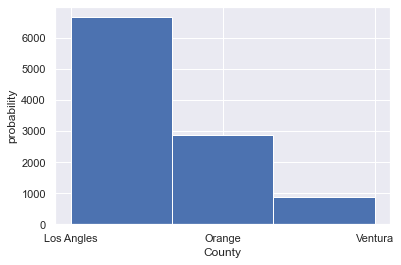

In [64]:
plt.hist(train.County, density=False, bins=3)
plt.ylabel('probability')
plt.xlabel('County')

Text(0.5, 0, 'Number of bathrooms')

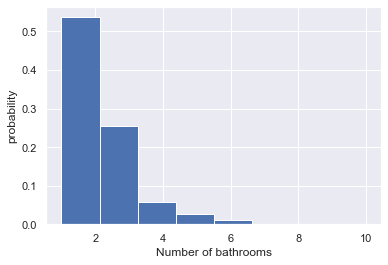

In [65]:
plt.hist(train.bathrooms, density=True, bins=8)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Number of bathrooms')


Text(0.5, 0, 'Number of bedrooms')

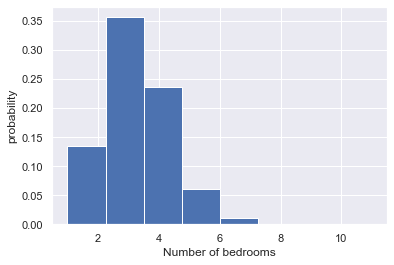

In [66]:
plt.hist(train.bedrooms, density=True, bins=8)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Number of bedrooms')



Text(0.5, 0, 'Year built')

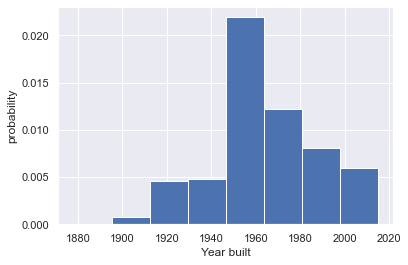

In [67]:
plt.hist(train.year_built, density=True, bins=8)  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Year built')

Text(0.5, 0, 'Square Feet')

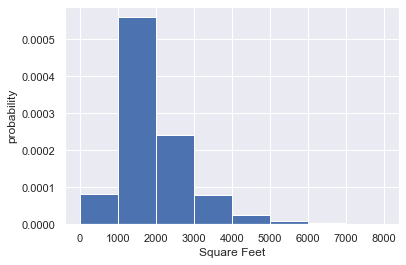

In [68]:
plt.hist(train.square_feet, density=True, bins=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000])  # `density=False` would make counts
plt.ylabel('probability')
plt.xlabel('Square Feet')

Text(0.5, 0, 'tax_rate')

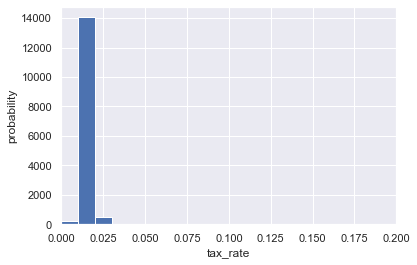

In [69]:
plt.hist(df.tax_rate, density=False, bins=[0, 0.01, 0.02, 0.03, 0.04, 0.05])  # `density=False` would make counts
plt.ylabel('probability')
plt.xlim(0,0.2)
plt.xlabel('tax_rate')

(0.0, 0.04)

<Figure size 864x432 with 0 Axes>

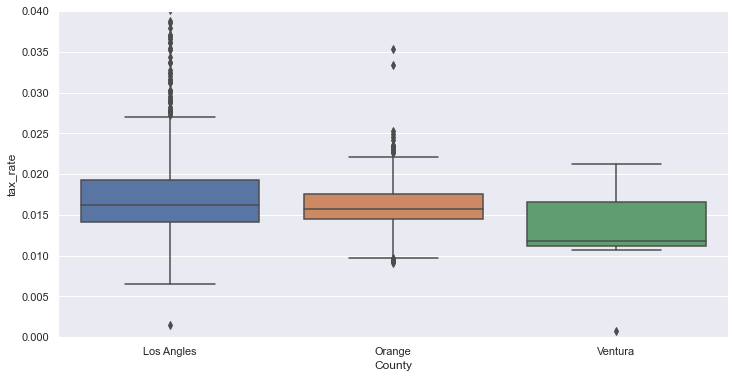

In [70]:
plt.figure(figsize=(12,6))
plt.figure(figsize=(12,6))
sns.boxplot(x= train[train.assessed_value<100000].County, y= train[train.assessed_value<100000].tax_rate, data=train[train.assessed_value<100000])
plt.ylim(0,0.04)

# It seems like tax rate (average) is higher compared to Orange and Ventura counties

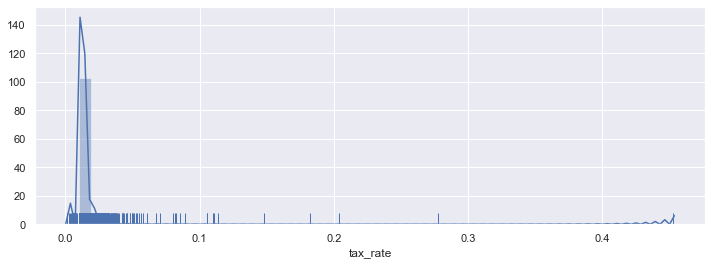

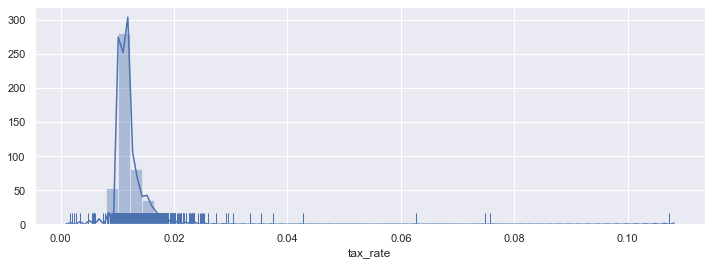

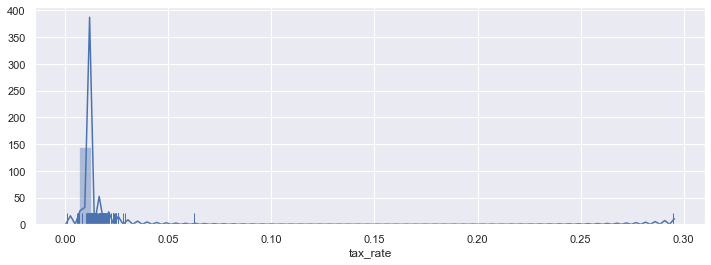

In [71]:
plt.figure(figsize=(12,4))
# below are plots for tax_rate distributions in three counties
sns.distplot(df[df.County == 'Los Angles'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Orange'].tax_rate, rug=True)
plt.show()
plt.figure(figsize=(12,4))
sns.distplot(df[df.County == 'Ventura'].tax_rate, rug=True)

# Lets see if we can add new features to our model. We start by exploring other variables and their correlation with home values. We will use train data for this exploration

In [149]:
train_plot2 = train[['assessed_value','bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'year_built']]
X_train2 = train[['bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'year_built']]
X_test2 = test[['bedrooms', 'bathrooms', 'square_feet', 'lot_size', 'year_built']]

In [152]:
cm = train_plot2.corr()
cm

,assessed_value,bedrooms,bathrooms,square_feet,lot_size,year_built
assessed_value,1.000,0.264,0.505,0.589,0.132,0.171
bedrooms,0.264,1.000,0.642,0.628,0.087,0.391
bathrooms,0.505,0.642,1.000,0.855,0.160,0.524
square_feet,0.589,0.628,0.855,1.000,0.206,0.464
lot_size,0.132,0.087,0.160,0.206,1.000,0.084
year_built,0.171,0.391,0.524,0.464,0.084,1.000


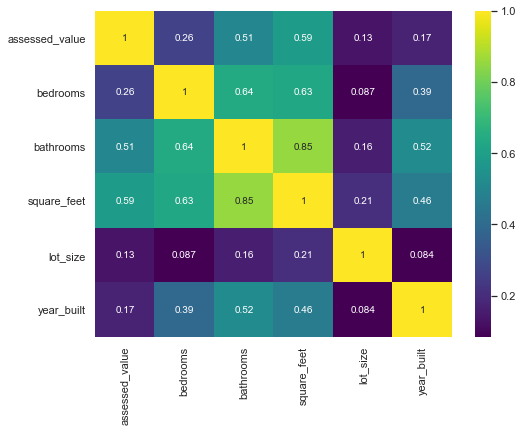

In [77]:
# lets look at heatmap and corresponding correlation values 
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='viridis')

The heatmap suggests some correlation between lot_size,year_built and home value too.

The histograms above for bedroom, bathroom and square_feet are right skewed. We can possibly tranform the data using log scale to make them more 'normal'

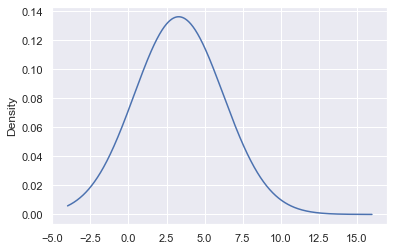

In [72]:
df.bedrooms.plot.kde(bw_method=3)


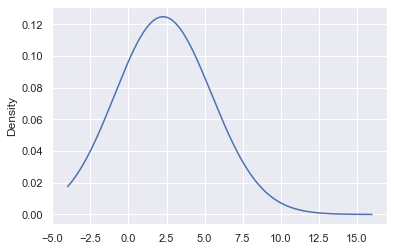

In [73]:
df.bathrooms.plot.kde(bw_method=3)

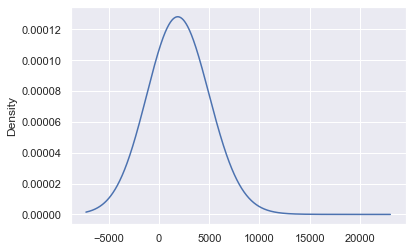

In [74]:
df.square_feet.plot.kde(bw_method=3)

lets use standard scaler and scale all independent variables

In [153]:
scaler, X_train_scaled,  X_test_scaled= split_scale.standard_scaler(X_train2, X_test2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e46f410>,
      dtype=object)

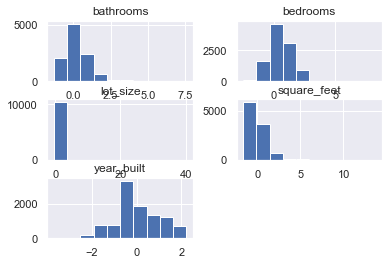

In [155]:
X_train_scaled.hist()

In [156]:
y_train = train[['assessed_value']]

In [157]:
lm = LinearRegression()

In [158]:
rfe = RFE(lm, 4)

In [159]:
X_rfe = rfe.fit_transform(X_train_scaled,y_train)

In [160]:
mask = rfe.support_

# select the column names of the features that were selected and convert them to a list for future use. 
rfe_features = X_train_scaled.columns[mask]

# print them out here for our reference
print(f'selected {len(rfe_features)} features:', ', '.join(rfe_features))

selected 4 features: bedrooms, bathrooms, square_feet, year_built


In [161]:
lm = LinearRegression()

In [162]:
lm.fit(X_rfe, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [163]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("features: ", rfe_features)
print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [543785.23868985]
features:  Index(['bedrooms', 'bathrooms', 'square_feet', 'year_built'], dtype='object')
coefficients:  [[-127526.36099824   99396.59072481  461244.19061543  -93505.79438792]]


In [176]:
X_rfe

array([[-0.34076565,  0.6631736 ,  0.19483605,  1.05399818],
       [ 0.73789387, -0.32139686, -0.23682519, -0.15232341],
       [-0.34076565, -0.32139686,  0.07701793, -1.18631334],
       ...,
       [-0.34076565, -0.32139686, -0.49277492, -0.49698672],
       [ 0.73789387,  0.17088837,  0.6264973 ,  1.65715898],
       [ 0.73789387, -0.32139686, -0.47550847, -0.02307466]])

In [165]:
predictions['yhat_lm_rfe'] = lm.predict(X_rfe)

In [166]:
predictions.apply(lambda col: sqrt(mean_squared_error(predictions.actual, col)))

actual             0.000
yhat_lm       571669.882
baseline      734625.255
yhat_lm_rfe   566136.925
dtype: float64

# Lets apply Linear Regression model using the selected features above

In [168]:
X_test_scaled.head()

,bedrooms,bathrooms,square_feet,lot_size,year_built
9116,-0.341,0.663,0.906,-0.233,0.666
2397,-0.341,0.171,0.834,-0.185,1.614
2849,-0.341,-0.321,-0.784,-0.125,-0.497
14308,1.817,0.663,1.177,-0.052,2.131
9780,-0.341,-0.321,0.065,-0.109,-0.109


In [169]:
X_test_rfe = rfe.transform(X_test_scaled)

In [170]:
len(X_test_rfe)

4462

In [171]:
y_test1 = test[['assessed_value']]
y_test1['test_prediction'] = lm.predict(X_test_rfe)

In [172]:
print("Linear Model:", lm)

print("intercept: ", lm.intercept_)

print("coefficients: ", lm.coef_)

Linear Model: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
intercept:  [543785.23868985]
coefficients:  [[-127526.36099824   99396.59072481  461244.19061543  -93505.79438792]]


In [173]:
y_test1.head()

,assessed_value,test_prediction
9116,1352462.000,1008659.075
2397,797339.000,837838.937
2849,63577.000,240025.759
14308,621836.000,721657.385
9780,362761.000,595413.097


In [174]:
y_test1.apply(lambda col: sqrt(mean_squared_error(y_test1.assessed_value, col)))

assessed_value         0.000
test_prediction   569747.128
dtype: float64

The test data has similar RMSE as train data. This means our model is not overfitted

Lets try this model on test data 

In [ ]:
y_test1['test_prediction'] = lm.predict(X_test_scaled_rfe)

In [175]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_rfe)

poly.get_feature_names()

['1',
 'x0',
 'x1',
 'x2',
 'x3',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x2^2',
 'x2 x3',
 'x3^2']

In [178]:
lm_poly = LinearRegression()
lm_poly.fit(X_poly, y_train.assessed_value)
y_train['yhat_poly'] = lm_poly.predict(X_poly)

In [179]:
y_train

,assessed_value,yhat_poly
11938,268557.000,665397.268
790,95849.000,304012.126
3846,324613.000,588795.710
14846,499860.000,715074.443
1469,517777.000,320495.662
...,...,...
12119,1321024.000,852420.072
8039,447349.000,321359.367
14147,665588.000,351919.440
6936,518732.000,534956.046


In [181]:
y_train.apply(lambda col: sqrt(mean_squared_error(y_train.assessed_value, col)))

assessed_value        0.000
yhat_poly        547161.646
dtype: float64

# polynomial model is only marginally better

# lets try to create new feature with Log scale (I am using Log with base 2). Square feet and lot size are good candidates for log scale

In [182]:
df.head()

,bathrooms,bedrooms,square_feet,fips,lot_size,pool,zip_code,year_built,latitude,longitude,assessed_value,tax_value,transaction_date,tax_rate,County
0,2.000,3.000,1458.000,6037,8284,1,97318,1970,34686163.000,-118113100.000,136104.000,2319.900,2017-06-23,0.017,Los Angles
1,1.000,2.000,1421.000,6037,6707,0,96018,1911,33999877.000,-118291863.000,35606.000,543.690,2017-06-30,0.015,Los Angles
2,3.000,4.000,2541.000,6059,4975,0,96958,2003,33694636.000,-117912245.000,880456.000,9819.720,2017-06-01,0.011,Orange
3,2.000,3.000,1650.000,6037,7300,0,96037,1949,33985377.000,-118361620.000,614000.000,7673.190,2017-06-01,0.012,Los Angles
4,1.000,2.000,693.000,6037,2908,0,96023,1921,34112946.000,-118208106.000,274237.000,3267.470,2017-06-29,0.012,Los Angles


In [183]:
import math

In [186]:
df['log2_sf'] = math.log(df.square_feet, 2.0)

TypeError: cannot convert the series to <class 'float'>